<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-2-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Deep Learning for Option Pricing

In [1]:
!pip install -q smt

     |████████████████████████████████| 252 kB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 357 kB/s 
     |████████████████████████████████| 3.1 MB 46.5 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 100 kB 8.2 MB/s 
     |████████████████████████████████| 121 kB 55.9 MB/s 
     |████████████████████████████████| 90 kB 7.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import sys
import math
import time
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from scipy.stats             import norm
from sklearn.model_selection import train_test_split

## Introduction

The problem of this first part of our lessons can be stated simply as follow. Let's say, from a very general point of view, that we have a contingent claim $\cal{V}$ that depends on $D$ parameters:

$$
\cal{V}(\mathbf{x}), \, \mathbf{x}=\left\{x_1,\dots, x_D \right\} \in \mathbb{R}^D
$$

We want to approximate the pricing function with a neural network. Remember that we can always consider the NN as a sort of mapping function 

$$
\Phi : \mathbb{R}^D \rightarrow \mathbb{R}
$$

trained to compute prices given a point in $\mathbb{R}^D $ representing a particular set of parameters. 

The use of a NN as a pricing functions has a number of advantages. the first is that in this way we are able to compute efficiently thousands of prices in a small amount of time, even when the derivative contract has complicated conditions and when the model is complex. This comes with the downside that the neural network may introduce systematic errors that could affect our estimation of the sensitivities in a number of ways. 

The second advantage is that instead of training the network on the model parameters, which in general are not observable, we could train the network ***using data that is directly observable in the market***. For example quotes and trades by market participants provide points on the
volatility surface. Interpolating between these points as necessary, a trader can derive a reasonable
estimate of the implied volatility appropriate for any new plain vanilla European or American
option that is of interest. Plain vanilla options are therefore not priced using a model. They are
simply priced to be consistent with the market. 

The volatility surface derived from the Black–Scholes–Merton model is a convenient interpolation tool for doing this.

Exotic options are generally not as actively traded as plain vanilla options and, as a result, a
model is required for pricing. A variety of different models are used in practice. Two conditions
that traders would like the model to satisfy are:

- A. The stochastic behavior assumed for the underlying asset price should correspond reasonably well to its observed behavior, and

- B. The volatility surface derived from the model should be reasonably consistent with the volatility surface used to price plain vanilla options.

Two categories of models that are used in practice can be distinguished. The models in the first
category focus on condition A by assuming a process for the asset price that is roughly consistent
with its observed behavior. The models have parameters that can be chosen to provide an
approximate fit to the current volatility surface. Models in the second category focus on condition B
and are designed to be exactly consistent with the current volatility surface.

Many different models in the first category involving stochastic volatility and jumps have been
proposed. Examples of stochastic volatility models are Hull and White (1987) and Heston (1993).
Merton (1976) proposed a model that overlays Black-Scholes-Merton model with jumps. Bates
(1996) adds jumps to Heston (1993). Madan et al (1998) propose a variance–gamma model where
there are only jumps. More recently, rough volatility models where the process for volatility is
non-Markov have been suggested by authors such as Gatheral et al (2018).

The second category of models are referred to as local volatility models. The original onefactor
local volatility model was suggested by Dupire (1994) and Derman and Kani (1994). It has been extended by authors such as Ren et al (2007) and Saporito et al (2019). Local volatility
models by design satisfy condition B.

The usual approach to implementing models in the first category is to choose model
parameters to fit the volatility surface as closely as possible. This approach, which we refer to as
the “model calibration approach” or MCA. A drawback of the approach is that some of the points on the volatility
surface are likely to be more important than others for any particular exotic option that is
considered. It is of course possible to vary the weights assigned to different points on the volatility
surface according to the instrument being valued. However, it is difficult to determine in advance
what these weights should be. As a result, the points are usually given equal weight when model
parameters are determined.

Neural networks can be used in
conjunction with MCA to provide fast pricing once model parameters have been determined.
Consider an exotic option that is valued using Monte Carlo simulation. As a first step, it is necessary
to devote computational resources to creating a data set relating model parameters and exotic
option parameters to the price. The pricing model can then be replicated with a neural network.
Once this has been done, valuation is several orders of magnitude faster than Monte Carlo
simulation because it involves nothing more than a forward pass through the neural network.

In this first notebook we will look at a simple example of this approach. For the sake of simplicity we will consider an example based on the Black and Scholes model for the pricing of a simple European option.

In the second part of these lessons we'll see how to train a neural network on market data (volatility surface) using the heston model as the underlying model.

## The Black and Scholes Model

We consider an underlying process $S(t)$ described by the sde

\begin{equation}
dS(t) = a(S,t) dt + b(S,t)dW
\end{equation}

A scenario is a set of values $\hat S^j (t_i), \> i=1,\dots,I$ that are an approximation to the $j-th$ realization,$S^j (t_i)$, 
of the solution of the sde evaluated at times $0 \le t_i \le T, \> i=1,\dots,I$.
A scenario is also called a trajectory. A trajectory can be visualized as a line in the state-vs-time plane describing the path 
followed by a realization of the stochastic process (actually by an approzimation to the stochastic process).

The Black and Scholes model assumes a market in which the tradable assets are:

1. A risky asset, whose evolution is driven by a geometric brownian motion

\begin{equation}
dS = \mu S dt + \sigma S dw \Rightarrow S(T)=S(t_0) e^{(\mu-\frac{1}{2} \sigma^2) (T-t_0) + \sigma[w(T) - w(t_0)]}
\end{equation}

2. The money market account, whose evolution is deterministic

\begin{equation}
dB=Brdt \Rightarrow B(T) = B(t_0) e^{r(T-t_0)}
\end{equation}

The value for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

\begin{equation}\label{eq:1}
C(S_{t},t)  =N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)} 
\end{equation}

\begin{equation} \label{eq:2}
P(S_{t},t) = N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}
\end{equation}

where

\begin{align}
d_{1} &={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\
d_{2} &= d_{1}-\sigma {\sqrt {T-t}}
\end{align}


For both:

- $N(\cdot )$ is the cumulative distribution function of the standard normal distribution
- $T-t$ is the time to maturity (expressed in years)
- $S_{t}$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
- $\sigma$  is the volatility of returns of the underlying asset


### Simpler formulation for vanilla options

Up until now, we described the pricing of instruments with general payos
and in particular of vanilla options. In the latter case, starting from the
expression of the vanilla put option price

$$
P_t = \mathbb{E} \left[e^{-r(T-t)} (K-S_T)^+ \right] 
$$

if we extract from the expected value $S_t$ we get

$$
P_t = S_t \mathbb{E} \left[ \left( e^{-r(T-t)} \frac{K}{S_T} - M_T \right)^+ \right] 
$$

where $M_T = e^{-r(T-t)}S_T/S_t$ is the stochastic process of a martingale with the
same volatility of $S_t$ and $M_t = 1$. By comparing this expression with the one
from the Black Scholes formula, we notice that we can in general rewrite the
price of a vanilla put option as

$$
P_(S_t,K,T,\sigma,r) = S_t P(1, e^{-r(T-t)} K/{S_T}, T, \sigma, 0)  
$$

From this we can see that we can calculate the price of any vanilla put option
by calculating the value of a simpler put option with $r = 0$, $S_t = 1$ and
$e^{-r(T-t)}K/S_t$ in place of the strike price. The exact same argument can be
made for a vanilla call option. For simplicity, in the rest of this work we will
always consider $r = 0$, since we don't lose any generality when the risk-free
rate is independent of the asset price.

In [3]:
#
# NumPy enabled asset or nothing
#
def __npan__ ( Fw, T, sgma, k):
    s          = sgma*np.sqrt(T)
    mask       = np.where( s <  1.e-8, 1, 0)
    MASK       = np.where( s >= 1.e-8, 1, 0)
    s          = np.where(mask, 1., s)
    dm         = ( np.log(k/Fw) -.5*s*s)/s
    an         = norm.cdf(dm)

    m1         = np.logical_and(mask, Fw <= k)
    res        = np.where(m1, 1., 0.)
    res       += np.where(MASK,an,0.0);

    return res
#
# NumPy enabled cash or nothing
#
def __npcn__ ( Fw, T, sgma, k):
    s          = sgma*np.sqrt(T)
    #print("npcn: s = %f" %s)
    mask       = np.where( s <  1.e-8, 1, 0)
    MASK       = np.where( s >= 1.e-8, 1, 0)
    s          = np.where(mask, 1., s)
    dp         = ( np.log(k/Fw) + .5*s*s)/s
    cn         = norm.cdf(dp)

    m1         = np.logical_and(mask, Fw <= k)
    res        = np.where(m1, 1., 0.)
    res       += np.where( MASK,cn,0.0);

    return res

def np_fw_euro_put(F, T, sgma, k):
    return k*__npcn__( F, T, sgma, k)  - F*__npan__( F, T, sgma, k) 

def np_fw_euro_call(F, T, sgma, k):
    return np_fw_euro_put(F, T, sgma, k) + F - k

def np_euro_put(So, r, T, sigma, k):
    Fw = np.exp(r*T)*So
    return np.exp(-r*T)*np_fw_euro_put(Fw, T, sigma, k)

def np_euro_call(So, r, T, sigma, k):
    Fw = np.exp(r*T)*So
    return np.exp(-r*T)*np_fw_euro_call(Fw, T, sigma, k)

## Training Data Generation

To train the network to approximate the pricing function, we need a training dataset. For the network approximating the Black Scholes pricing function, we created one by drawing $T, K/S_0$ and $\sigma$ using the Latin Hypercube Sampling (LHS) (see below) within the ranges usually found in real market.

### Sampling Utilities

**Latin Hypercube Sampling** (from Wikipedia)

Latin hypercube sampling (LHS) is a statistical method for generating a near-random sample of parameter values from a multidimensional distribution. The sampling method is often used to construct computer experiments or for Monte Carlo integration. In the context of statistical sampling, a square grid containing sample positions is a Latin square if (and only if) there is only one sample in each row and each column. A Latin hypercube is the generalisation of this concept to an arbitrary number of dimensions, whereby each sample is the only one in each axis-aligned hyperplane containing it.

When sampling a function of $N$ variables, the range of each variable is divided into $M$ equally probable intervals. $M$ sample points are then placed to satisfy the Latin hypercube requirements; this forces the number of divisions, $M$, to be equal for each variable. This sampling scheme does not require more samples for more dimensions (variables); this independence is one of the main advantages of this sampling scheme. Another advantage is that random samples can be taken one at a time, remembering which samples were taken so far.

In two dimensions the difference between random sampling, Latin hypercube sampling, and orthogonal sampling can be explained as follows:

- In random sampling new sample points are generated without taking into account the previously generated sample points. One does not necessarily need to know beforehand how many sample points are needed.
- In Latin hypercube sampling one must first decide how many sample points to use and for each sample point remember in which row and column the sample point was taken. Such configuration is similar to having N rooks on a chess board without threatening each other.
- In orthogonal sampling, the sample space is divided into equally probable subspaces. All sample points are then chosen simultaneously making sure that the total set of sample points is a Latin hypercube sample and that each subspace is sampled with the same density.

Thus, orthogonal sampling ensures that the set of random numbers is a very good representative of the real variability, LHS ensures that the set of random numbers is representative of the real variability whereas traditional random sampling (sometimes called brute force) is just a set of random numbers without any guarantees.

<!--
<div>
<img src='../07-pictures/03_intro_to_deep_learning_pic_0.png'  width="600">
</div>
-->
![caption](https://github.com/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/pic/chapter-2_pic_2.png?raw=1)

In [4]:
from smt.sampling_methods import LHS

def lhs_sampling(rand, NUM, bounds=None):

    # remember that the result of apply the function list to
    # a python dictionary is a list containing dict's keys
    kw   = list(bounds)

    # builds the array of bounds
    limits = np.empty(shape=(0,2))
    for k in kw: 
        limits = np.concatenate((limits, [bounds[k]]), axis=0)

    sampling = LHS(xlimits=limits)
    x        = sampling(NUM)

    X = pd.DataFrame()
    for n in range(len(kw)):
        tag    = kw[n]
        X[tag] = x[:,n]

    return X

### Sample Generator

We assume $r = q = 0, S_0 = 1$ and create a data set of 1000000 observations by  randomly sampling from uniform distributions for the other five inputs  to the Black−Scholes−Merton formula. The lower and upper bounds of  the uniform distributions are as indicated in the `bounds` dictionary. For each set of  parameters sampled, we calculate the Black−Scholes−Merton price using equations \eqref{eq:1} and \eqref{eq:2}. 

In [30]:
# For the neural network calculating the vanilla option prices in the Black Scholes model, 
# the features used are the time to maturity T, the moneyness (simply defined as 'Strike') 
# and the asset volatility sigma.
#
# Lower and upper boundaries for each parameter
#
bounds = {  "T"     : [1./12., 2.00]
          , "Sigma" : [ .01  ,  .80]
          , "Strike": [ .4   , 1.20]
         }
#
# Number of Observations
#
NUM = 100000
#
# Random number generator
#
seed = 42
rand = np.random.RandomState()
#
# Latin Hypercube Sampling
#
xDF = lhs_sampling(rand, NUM, bounds=bounds)
xDF.head()

,T,Sigma,Strike
0,0.677625,0.078481,0.548412
1,1.645944,0.241506,0.840500
2,1.303876,0.035584,0.672996
3,0.170360,0.270183,0.745020
4,0.334790,0.123622,1.069436


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c588ad210>,
      dtype=object)

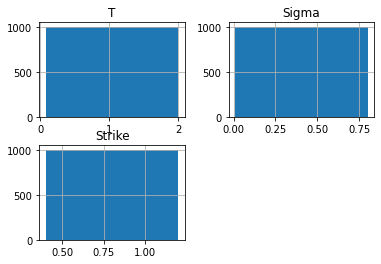

In [31]:
xDF.hist(bins=100)

In [32]:
def gen(NUM, pars):

    S0     = np.full(NUM, 1.0, dtype = np.double)
    r      = np.full(NUM, 0.0, dtype = np.double)
    price  = np_euro_call(S0, r, pars["T"], pars["Sigma"], pars["Strike"])
    
    df = pd.DataFrame(pars)
    df["Price"] = price

    return df

In [33]:
__tStart = time.perf_counter()
df =  gen(NUM, xDF)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd - __tStart) )

df.head()

@ GEN                               : elapsed 0.0653 sec


,T,Sigma,Strike,Price
0,0.677625,0.078481,0.548412,0.451588
1,1.645944,0.241506,0.840500,0.210217
2,1.303876,0.035584,0.672996,0.327004
3,0.170360,0.270183,0.745020,0.255104
4,0.334790,0.123622,1.069436,0.006916


In [34]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)
print(len(X_train), len(X_test))
X_train.head()

67000 33000


,T,Sigma,Strike,Price
59428,1.580911,0.454940,1.196316,0.160744
34957,1.952860,0.686505,0.770388,0.452055
4264,1.132124,0.555926,0.954092,0.250895
53791,1.279650,0.693551,0.629452,0.472963
82114,0.762686,0.685493,0.655044,0.411693


In [35]:
X_test.head()

,T,Sigma,Strike,Price
75721,0.374676,0.145078,1.110924,0.005416
80184,1.663232,0.620429,0.840036,0.372400
19864,0.194280,0.304303,0.635956,0.364054
76699,0.521014,0.224094,0.618300,0.381753
92991,1.447300,0.022644,0.453652,0.546348


To make the illustration more interesting, we then  add a random error to each calculated price. The random error is normally distributed with a mean of zero and a standard deviation of $\epsilon \cdot (P_{max} - P_{min})$ where $\epsilon$ is a scale parameter defined by the user.

In [36]:
def add_noise(rand, Xv, eps):
    X  = Xv.copy()
    xl = np.min(X["Price"])
    xh = np.max(X["Price"])

    xi = rand.normal( loc = 0.0, scale = eps*(xh-xl), size=X.shape[0])
    X["Price"] += xi
    return X

In [37]:
EPS = 0.0
if EPS > 0.0: 
    X_train = add_noise(rand, X_train, EPS)

In [38]:
y_train = X_train['Price']
y_test  = X_test['Price']

Text(0.5, 0, 'BS Price')

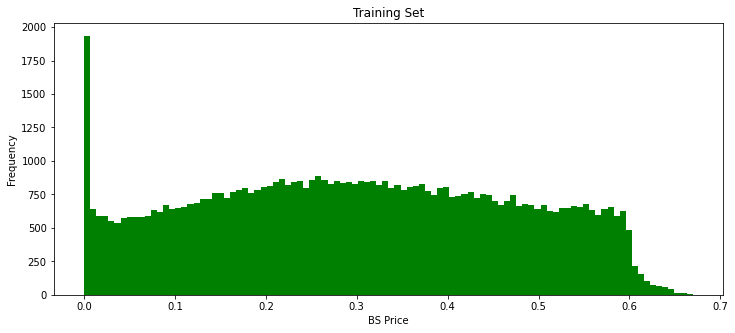

In [39]:
ax=y_train.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='green', title = 'Training Set')
ax.set_xlabel('BS Price')

Text(0.5, 0, 'BS Price')

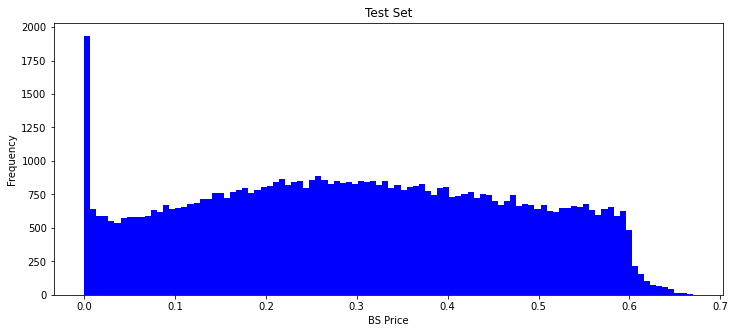

In [40]:
ax=y_train.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='blue', title = 'Test Set')
ax.set_xlabel('BS Price')

In [41]:
X_train = X_train.drop(['Price'], axis=1)
X_test  = X_test.drop(['Price'], axis=1)
X_train.head()

,T,Sigma,Strike
59428,1.580911,0.454940,1.196316
34957,1.952860,0.686505,0.770388
4264,1.132124,0.555926,0.954092
53791,1.279650,0.693551,0.629452
82114,0.762686,0.685493,0.655044


### Scaling Data

In [42]:
from sklearn.preprocessing import StandardScaler

scaling = True

if scaling:
    # Scale the train set
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # Scale the test set
    scaler = StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)
    
    # Transform into pd DataFrame
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

## Create the Model

### Neural Network Architecture

We use mean absolute error (mae) as the cost function. The neural  network has two hidden layers and a decreasing number of neurons per layer. The relu activation function is used. 

In [43]:
from keras.models import Sequential
from keras.layers import Dense

**The input shape**

What flows between layers are tensors. Tensors can be seen as matrices, with shapes. Shapes are consequences of the model's configuration. Shapes are tuples representing how many elements an array or tensor has in each dimension.

> Ex: a shape (30,4,10) means an array or tensor with 3 dimensions, containing 30 elements in the first dimension, 4 in the second and 10 in the third, totaling 30*4*10 = 1200 elements or numbers.

In Keras, the input layer itself is not a layer, but a tensor. It's the starting tensor you send to the first hidden layer. This tensor must have the same shape as your training data. 

> Ex: if you have 30 images of 50x50 pixels in RGB (3 channels), the shape of your input data is (30,50,50,3). Then your  input layer tensor, must have this shape.

Since the input shape is the only one you need to define, Keras will demand it in the first layer. 

In [44]:
def model_builder( inputShape = (1,)):
    
    # Initialize the constructor
    model = Sequential()

    # Start from the first hidden layer, since the input is not actually a layer   
    # But inform the shape of the input, with inputShape elements.    
    model.add(Dense(200, activation='relu', input_shape=inputShape))

    # Add one more hidden layer 
    model.add(Dense(200, activation='relu'))

    # Add one more hidden layer 
    model.add(Dense(200, activation='relu'))

    # Add an output layer 
    model.add(Dense(1))
    # End model construction

    # Model output shape
    print("model.output_shape: %s" %(str(model.output_shape)))

    # Model summary
    print("Model.summary"); model.summary()

    # Model config
    print("Model.config"); model.get_config()

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [45]:
model = model_builder( inputShape = (X_train.shape[1],))

model.output_shape: (None, 1)
Model.summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               800       
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 81,401
Trainable params: 81,401
Non-trainable params: 0
_________________________________________________________________
Model.config


## Train the Model

In [46]:
def show_scattered( y, t, TAG, ax = None):
    #x      = model.predict(X)
    #y      = np.ravel(x)
    xMin = min(t)
    xMax = max(t)
    v    = np.arange(xMin, xMax, (xMax-xMin)/100.)

    diff   = np.fabs(y - t)
    print("@ %-24s: E[y-t]: %.6f Std(y-t): %.6f" %( TAG, np.mean(diff), np.std(diff)))
    if ax == None: return

    ax.plot( y, t, ".")
    ax.plot( v, v, color="red")
    ax.set_title("%s mae=%8.4f, std=%8.4f" %(TAG, np.mean(diff), np.std(diff)))
    ax.set_xlabel("predicted")
    ax.set_ylabel("target")

In [47]:
def display_nn_results( model, X_train, X_test, t_train, t_test, resFile=None):

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    fig.suptitle("Scattered plots")
    #
    # The numpy module ravel of NumPy provides a function, called numpy.ravel, which is used to change 
    # a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. The returned 
    # array has the same data type as the source array or input array.
    #
    y_train  = np.ravel(model.predict(X_train))
    show_scattered( y_train, t_train, "InSample", ax = ax[0])
    diff   = np.fabs(y_train - t_train)
    delta  = y_train - t_train
    RES    = pd.DataFrame({"predicted": y_train, "target": t_train, "err": diff, "delta": delta})
    h1     = RES['delta'] 
    RES.to_csv("res_in_sample.csv", sep=',', float_format="%.6f", index=True)
    print("@")
    
    y_test  = np.ravel(model.predict(X_test))
    show_scattered( y_test , t_test, "OutOfSample", ax= ax[1])
    diff   = np.fabs(y_test-t_test)
    delta  = y_test - t_test
    RES    = pd.DataFrame({"predicted": y_test, "target": t_test, "err": diff, "delta": delta})
    h2     = RES['delta']
    RES.to_csv("res_ou_sample.csv", sep=',', float_format="%.6f", index=True)
    print("@")

    if resFile != None:
        plt.savefig(resFile, format="png")
        print("@ %-12s: results saved to '%s' "%("Info", resFile))
    plt.show()


    score = model.evaluate(X_test, t_test, verbose=1)
    print('Score:'); print(score)
    
    h1.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='blue', title = 'err distribution')
    h2.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='red')


In [48]:
frames = [X_train, X_test]
X = pd.concat(frames)

frames = [y_train, y_test]
Y = pd.concat(frames)


In [49]:
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=10, verbose=1)


Epoch 1/10
2094/2094 [==============================] - 10s 4ms/step - loss: 5.2272e-04 - mae: 0.0137 - val_loss: 7.1412e-05 - val_mae: 0.0075
Epoch 2/10
2094/2094 [==============================] - 9s 4ms/step - loss: 8.7117e-05 - mae: 0.0071 - val_loss: 3.8192e-05 - val_mae: 0.0053
Epoch 3/10
2094/2094 [==============================] - 8s 4ms/step - loss: 6.1124e-05 - mae: 0.0059 - val_loss: 1.6314e-04 - val_mae: 0.0102
Epoch 4/10
2094/2094 [==============================] - 8s 4ms/step - loss: 5.0812e-05 - mae: 0.0054 - val_loss: 1.0009e-05 - val_mae: 0.0025
Epoch 5/10
2094/2094 [==============================] - 9s 4ms/step - loss: 4.4250e-05 - mae: 0.0051 - val_loss: 7.7241e-05 - val_mae: 0.0078
Epoch 6/10
2094/2094 [==============================] - 9s 4ms/step - loss: 3.9031e-05 - mae: 0.0047 - val_loss: 4.8271e-05 - val_mae: 0.0059
Epoch 7/10
2094/2094 [==============================] - 9s 4ms/step - loss: 3.4736e-05 - mae: 0.0044 - val_loss: 3.7505e-05 - val_mae: 0.0055
Epoch

@ InSample                : E[y-t]: 0.003660 Std(y-t): 0.002250
@
@ OutOfSample             : E[y-t]: 0.003988 Std(y-t): 0.002286
@
@ Info        : results saved to 'training.png' 


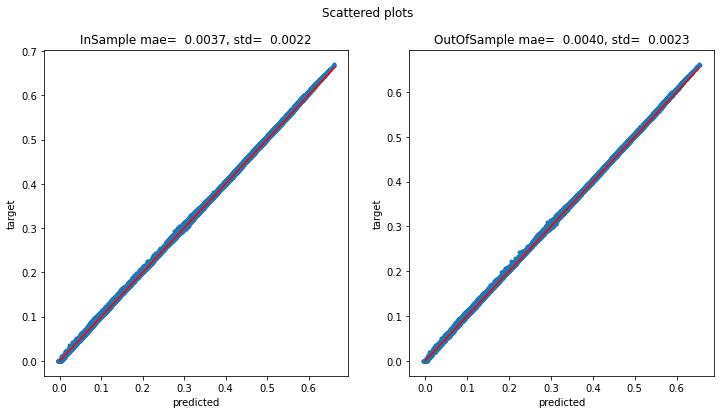

1032/1032 [==============================] - 2s 2ms/step - loss: 2.1132e-05 - mae: 0.0040
Score:
[2.1131665562279522e-05, 0.003988101612776518]


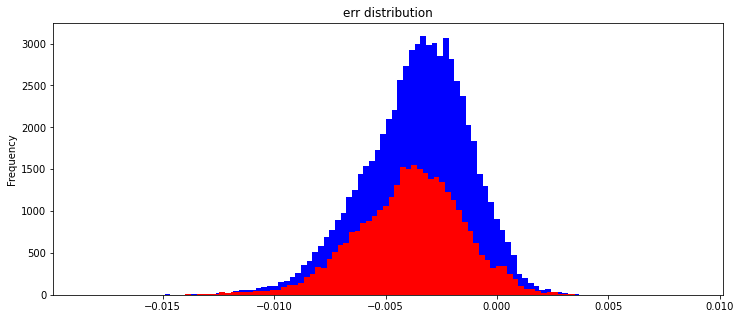

In [50]:
import warnings
warnings.simplefilter('ignore')

display_nn_results(model, X_train, X_test, y_train, y_test, resFile='training.png')

### Access Model Training History in Keras

Keras provides the capability to register callbacks when training a deep learning model. One of the default callbacks that is registered when training all deep learning models is the **History callback**. It records training metrics for each epoch. This includes the loss and the accuracy (for classification problems) as well as the loss and accuracy for the validation dataset, if one is set.

The history object is returned from calls to the fit() function used to train the model. Metrics are stored in a dictionary in the history member of the object returned.

For example, you can list the metrics collected in a history object using the following snippet of code after a model is trained:

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


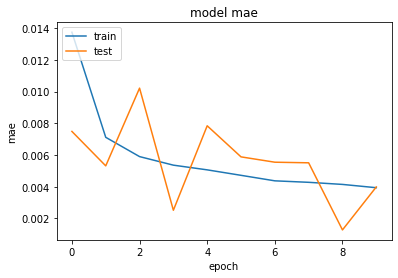

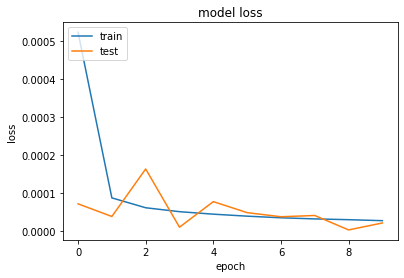

In [51]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the Model

In [52]:
TAG        = 'bs-0100000-050-T'
mdlDir     = "model_%s.krs" %(TAG)


model.save(mdlDir)
print("@ %-24s: model saved to '%s'" %("Info", mdlDir))  

INFO:tensorflow:Assets written to: model_bs-0100000-050-T.krs/assets
@ Info                    : model saved to 'model_bs-0100000-050-T.krs'
